# A guide to using PyLAT for carrying out tomographic reconstruction

## Load the necessary modules

In [33]:
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

from src import SinoGram, LineProj, TomoReconst, Phantom

## Create an input for laser configurations

In `PyLat`, laser configuration is determined by the **distance** and **angle** of each laser line relative to the geometric center (or the origin of the reconstruction volume). It is recommended to store this information in an external file for repeated access. The following is a sample list of laser lines in a configuration file:

```text
No	Distance [mm]	Angle [°]
0	-30	0
1	27.95	31.61
2	-27.95	31.61
3	-30	90
.
.
.
15	-10	0
```

The configuration can also be generated by using `SinoGram` for simple parallel laser arrangements.

In [26]:
size = 401  # Grid size, the finer the better but also takes longer to compute
sino =SinoGram(size).sinogram_parallel(4, 0.8)  # A total of 16 lines
sino


array([{'d': -160.0, 'theta': 0, 'center': None, 'axis': 'y'},
       {'d': -160.0, 'theta': 45, 'center': None, 'axis': 'y'},
       {'d': -160.0, 'theta': 90, 'center': None, 'axis': 'y'},
       {'d': -160.0, 'theta': 135, 'center': None, 'axis': 'y'},
       {'d': -53.33333333333333, 'theta': 0, 'center': None, 'axis': 'y'},
       {'d': -53.33333333333333, 'theta': 45, 'center': None, 'axis': 'y'},
       {'d': -53.33333333333333, 'theta': 90, 'center': None, 'axis': 'y'},
       {'d': -53.33333333333333, 'theta': 135, 'center': None, 'axis': 'y'},
       {'d': 53.33333333333334, 'theta': 0, 'center': None, 'axis': 'y'},
       {'d': 53.33333333333334, 'theta': 45, 'center': None, 'axis': 'y'},
       {'d': 53.33333333333334, 'theta': 90, 'center': None, 'axis': 'y'},
       {'d': 53.33333333333334, 'theta': 135, 'center': None, 'axis': 'y'},
       {'d': 160.0, 'theta': 0, 'center': None, 'axis': 'y'},
       {'d': 160.0, 'theta': 45, 'center': None, 'axis': 'y'},
       {'d': 16

As can be seen, `sino` is a list of dictionaries, each corresponds to a laser line. Using `SinoGram.sinogram_custom` to load custom list of randomly arranged laser lines:

In [28]:
sinolist = np.array(
    [[-160., 0],
     [-160., 45],
     [-160, 90],
     [-160, 135],
     [-53.3, 0],
     [-53.3, 45],
     [-53.3, 90],
     [-53.3, 135],
     [53.3, 0],
     [53.3, 45],
     [53.3, 90],
     [53.3, 135],
     [160, 0],
     [160, 45],
     [160, 90],
     [160, 135]])
sino = SinoGram(size).sinogram_custom(sinolist, norm_fac=401)  # norm_fac is essentially the actual physical size of the reconstruction volume. This matters only for absolute absorbance calculations
sino

array([{'d': -160.0, 'theta': 0.0, 'center': None, 'axis': 'y'},
       {'d': -160.0, 'theta': 45.0, 'center': None, 'axis': 'y'},
       {'d': -160.0, 'theta': 90.0, 'center': None, 'axis': 'y'},
       {'d': -160.0, 'theta': 135.0, 'center': None, 'axis': 'y'},
       {'d': -53.3, 'theta': 0.0, 'center': None, 'axis': 'y'},
       {'d': -53.3, 'theta': 45.0, 'center': None, 'axis': 'y'},
       {'d': -53.3, 'theta': 90.0, 'center': None, 'axis': 'y'},
       {'d': -53.3, 'theta': 135.0, 'center': None, 'axis': 'y'},
       {'d': 53.3, 'theta': 0.0, 'center': None, 'axis': 'y'},
       {'d': 53.3, 'theta': 45.0, 'center': None, 'axis': 'y'},
       {'d': 53.3, 'theta': 90.0, 'center': None, 'axis': 'y'},
       {'d': 53.3, 'theta': 135.0, 'center': None, 'axis': 'y'},
       {'d': 160.0, 'theta': 0.0, 'center': None, 'axis': 'y'},
       {'d': 160.0, 'theta': 45.0, 'center': None, 'axis': 'y'},
       {'d': 160.0, 'theta': 90.0, 'center': None, 'axis': 'y'},
       {'d': 160.0, 'theta

We arrive at the same laser configuration as the one generated automatically above

## Visualize laser configuration

To check if the laser lines are loaded correctly, it is recommended to visualize the laser configuration prior to performing any further reconstruction

Processing Laser-line #16 of 16 lines

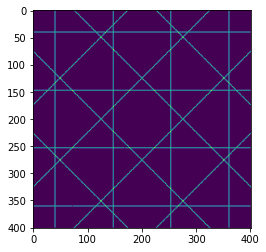

In [27]:
laser_config = LineProj(size=size)
laser_lines = laser_config.conf_vis(sino)
plt.imshow(laser_lines)
plt.show()

**Note**: the order of the laser lines is extremely important for later reconstruction. Any mismatch between the laser configuration and measured laser absorbance will lead to meaningless results. Therefore, it is important to make sure the visualized laser configuration matches the one implemented in the experiment. One can check the line number by deliberately removing one line out of the list and redo the visualization.

## Evaluate laser configuration with phantom distributions

It is important to test the laser configuration against *likely* or *expected* distributions in the measurement volume to get a sense of reconstruction accuracy. Here we can create some typical Gaussian "spots", commonly used in the field to examine LAT schemes.

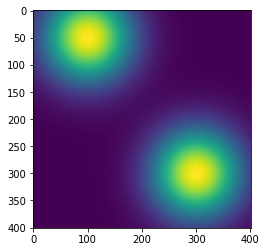

In [30]:
data_synth = Phantom(size=size, center=(100, 50)).gaussian(fwhm=size/3) + 1e-2
data_synth += Phantom(size=size, center=(300, 300)).gaussian(fwhm=size/3) + 1e-2
data_synth = data_synth/data_synth.max()
plt.imshow(data_synth)
plt.show()

Now we can calculate projections and absorbance:

In [32]:
size_reconst = 21  # chose a grid size for the reconstruction
laser_config = LineProj(size=size, img=data_synth)  # now using the synthetic distribution for calculating absorbance
laser_absorb = laser_config.absorbance(sino)
# compute the projections
proj = laser_config.path(sino, size_reconst=size_reconst)

Processing Laser-line #16 of 16 lines

Since `laser_config` is independent of the measurements and is only determined by the laser configuration, it is recommended to pickle this object for later easy access without repeated computation.

The reconstruction problem is obviously severely rank-deficient (only 16 lines for a reconstruction of 21x21) and the solution is non-unique without any other priories. Here we can introduce two simple physical constraints on the pixel values that apply to LAT relatively well:

* None-zero
* Smooth distribution

We can implement these as the following

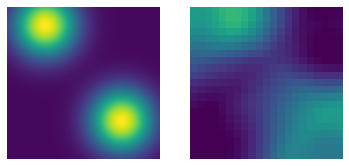

In [34]:
def reg_single(N, sigma=1):
    # smooth the field
    N = gaussian_filter(N, sigma=sigma, mode='reflect')
    N[N < 0.] = 0.0
    N[N > 1.] = 1.0

    return N


abs_reconst = TomoReconst(laser_config, laser_absorb)
data_reconst = abs_reconst.Landweber(reg_single, maxiter=500)
_, ax = plt.subplots(1, 2)
ax[0].imshow(data_synth, clim=[0, 1])
ax[1].imshow(data_reconst, clim=[0, 1])

for i in range(2):
    ax[i].axis('off')
plt.show()

On the left is the original distribution, on the right is the reconstruction. It is clear that with limited laser lines, the reconstruction quality can be very poor.

We can also use Tikhonov regularizations to carry out the reconstruction:

The maximum number of function evaluations is exceeded.
Number of iterations: 1000, function evaluations: 439348, CG iterations: 256865, optimality: 3.37e-05, constraint violation: 0.00e+00, execution time: 1.7e+02 s.
The maximum number of function evaluations is exceeded.


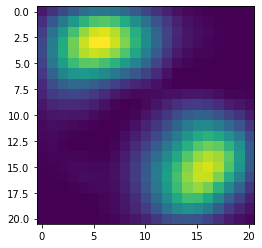

In [36]:
abs_reconst = TomoReconst(laser_config, laser_absorb)
res = abs_reconst.reg_tikhonov_1th(alpha=40)
print(res.message)
plt.imshow(np.reshape(res.x, [21, 21]))
plt.show()

This will sometimes take much longer and may never converge depending on the setup. So it's recommended to try one of the ART methods in `PyLAT` first. The value `alpha` affects the smoothness of the solution and can lead to distorted results if not correctly chosen.

To reconstruct experimental results, one only needs to supply measured absorbance as an array in `laser_absorb`.